# Title: Twitter US Airlines Sentiment Analysis

### Project Overview
This project aims to analyze the sentiment of tweets directed at various U.S. airlines. The dataset used in this analysis is the "Twitter US Airline Sentiment" dataset, which contains tweets classified as positive, neutral, or negative. The goal of this project is to build a machine learning model that can accurately predict the sentiment of tweets based on their text content.

### Dataset Description
The "Twitter US Airline Sentiment" dataset is publicly available on Kaggle and contains over 14,000 tweets about major U.S. airlines, labeled with sentiment categories. The dataset provides valuable insights into customer satisfaction and sentiment toward different airlines.

[Dataset URL](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

**Dataset Features**

| Feature                       | Description                                                                           |
|-------------------------------|---------------------------------------------------------------------------------------|
| `tweet_id`                    | Unique identifier for each tweet.                                                     |
| `airline_sentiment`           | The sentiment label for the tweet, which can be one of the following categories:      |
|                               | - positive                                                                           |
|                               | - neutral                                                                            |
|                               | - negative                                                                           |
| `airline_sentiment_confidence`| Confidence level in the sentiment classification.                                     |
| `negativereason`              | The reason for negative sentiment, if applicable (e.g., "Late Flight," "Cancelled Flight"). |
| `negativereason_confidence`   | Confidence level in the negative reason classification.                               |
| `airline`                     | The airline to which the tweet is directed (e.g., "United," "American").              |
| `airline_sentiment_gold`      | A gold standard label for the tweet's sentiment, if available.                        |
| `name`                        | The name of the user who posted the tweet.                                            |
| `negativereason_gold`         | A gold standard label for the negative reason, if available.                          |
| `retweet_count`               | The number of retweets for the tweet.                                                 |
| `text`                        | The actual tweet content.                                                             |
| `tweet_coord`                 | Coordinates of the tweet, if available.                                               |
| `tweet_created`               | The timestamp when the tweet was created.                                             |
| `tweet_location`              | The location of the tweet, if available.                                              |
| `user_timezone`               | The timezone of the user who posted the tweet.                                        |



In [ ]:
# Load Libraties

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random

import nltk
import string
import re
from nltk.corpus import stopwords,wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix, classification_report

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load Dataset

In [ ]:
# Load dataset
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Analysis

In [ ]:
# For this task the features that will be used are airline_sentiment and text
df = df[['airline_sentiment', 'text']]

df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [ ]:
# Shape
print('Dataset shape:', df.shape)

Dataset shape: (14640, 2)


In [ ]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [ ]:
# Missing values
print(f'This dataset has {df.isna().sum().sum()} missing values.')

This dataset has 0 missing values.


In [ ]:
# Duplicates
print(f'This dataset has {df.duplicated().sum()} duplicate values.\n')

df[df.duplicated()]

This dataset has 188 duplicate values.



,airline_sentiment,text
331,positive,@VirginAmerica Thanks!
515,positive,@united thanks
1477,positive,@united thank you!
1864,positive,@united thank you
1938,positive,@united thank you
...,...,...
13995,negative,@AmericanAir 800 number will not even let you...
14386,negative,@AmericanAir I want to speak to a human being!...
14392,negative,@AmericanAir no response to DM or email yet. ...
14543,negative,@AmericanAir should reconsider #usairways acqu...


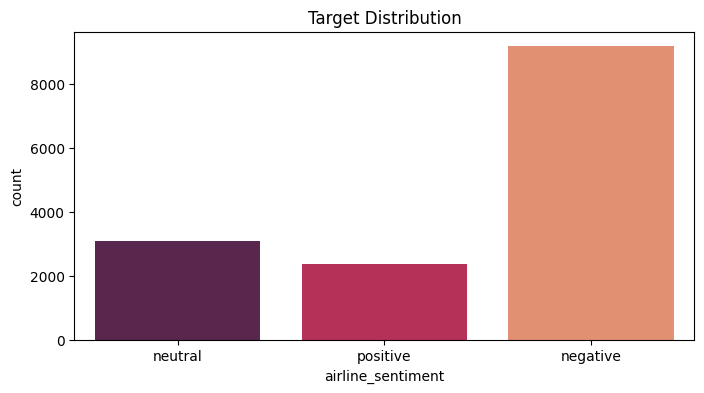

In [ ]:
# Target distribution
plt.figure(figsize = (8,4))
sns.countplot(data = df, x = 'airline_sentiment',hue ='airline_sentiment', palette='rocket')
plt.title('Target Distribution')
plt.show()

**Based on the analysis, this dataset contains no missing values.
There are 188 duplicate entries, which will be removed. The target variable is imbalanced, with the majority of sentiments being negative.**

## Preprocessing

In [ ]:
# Remove duplicates
df.drop_duplicates(inplace=True)

df[df.duplicated()]

,airline_sentiment,text


In [ ]:
# Encode target feature
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['airline_sentiment'] = df['airline_sentiment'].map(target_map)

In [ ]:
# Define part of speech tag function

def get_pos_tag(tag):

  if tag.startswith('N'):
    return wordnet.NOUN

  elif tag.startswith('V'):
    return wordnet.VERB

  elif tag.startswith('J'):
    return wordnet.ADJ

  elif tag.startswith('R'):
    return wordnet.ADV

  return wordnet.NOUN

In [ ]:
# Text preprocessing function
def preprocess_text(texts):

  # lowercase
  text = texts.lower()

  # remove hashtags and usernames
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'#\w+', '', text)

  # remove punctuations
  text = text.translate(str.maketrans('','', string.punctuation))

  # tokenize
  tokens = word_tokenize(text)

  #stopwords
  stop_words = stopwords.words('english')

  words = [word for word in tokens if word not in stop_words]

  # remove words with length smaller than 3
  words = [word for word in words if len(word) > 3]

  # lemmatization
  lemm = WordNetLemmatizer()

  postags = pos_tag(words)
  words = [lemm.lemmatize(word,get_pos_tag(tag)) for word,tag in postags]

  return ' '.join(words)

In [ ]:
# apply function
tqdm.tqdm.pandas()

df['text'] = df['text'].progress_apply(preprocess_text)

100%|██████████| 14452/14452 [00:21<00:00, 659.55it/s]


In [ ]:
df

,airline_sentiment,text
0,2,say
1,1,plus youve added commercial experience tacky
2,2,didnt today must mean need take another trip
3,0,really aggressive blast obnoxious entertainmen...
4,0,really thing
...,...,...
14635,1,thank different flight chicago
14636,0,leave minute late flight warning communication...
14637,2,please bring american airline
14638,0,money change flight dont answer phone suggesti...


## Load pretrained glove model

In [ ]:
# Load Glove for twitter
! wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
! unzip glove.twitter.27B.zip

In [ ]:
# Define function to load glove emeddings

def load_glove(filepath):

  # dictionary to store words and corresponding vector
  word_vecs = {}

  with open(filepath, 'r', encoding = 'utf-8') as file:
    for line in file:

      # split and extract words and vectors
      parts = line.split()
      words = parts[0]
      vectors = np.array(parts[1:], dtype = np.float32)

      # add each word and corresponding vector
      word_vecs[words] = vectors

  return word_vecs

In [ ]:
# Apply function
glove_vectors = load_glove('glove.twitter.27B.100d.txt')

In [ ]:
glove_vectors['hate']

array([-8.9292e-02,  2.5274e-02,  3.4284e-01,  7.6280e-01, -5.7351e-01,
        1.6100e-01,  2.6045e-01,  2.3925e-01,  1.5588e-01,  8.3302e-01,
        1.3197e-01, -6.0437e-01, -4.8413e+00, -3.6953e-01, -2.6325e-01,
        2.2827e-01, -2.8467e-02, -6.2125e-02, -7.3927e-01, -1.1180e-01,
       -3.6183e-01,  5.6196e-01, -4.4906e-01, -2.2146e-01,  3.6480e-01,
       -5.6021e-04,  5.4443e-03,  6.3700e-01,  8.9191e-02, -1.3665e-01,
       -3.0903e-01, -7.9537e-01, -6.4433e-01, -1.3414e-01, -6.7841e-01,
       -1.4054e-01, -4.2698e-01,  5.0116e-01,  1.0525e+00,  4.0846e-01,
       -5.8279e-01,  2.2667e-01, -3.3987e-01, -9.8294e-02, -2.6488e-01,
        3.8697e-01,  6.7846e-02,  2.7843e-01, -2.3891e-01, -1.6005e-01,
       -5.8679e-01,  9.1780e-01,  2.3170e-01, -9.3170e-02,  3.6210e-01,
        2.0116e-01, -1.4328e+00, -4.8323e-01, -1.7617e-01,  3.3622e-02,
       -2.7653e-02,  7.3344e-01, -1.8992e-01, -6.7464e-01, -2.0995e-01,
        9.8454e-02, -2.6406e-01,  7.4438e-01, -1.6099e-01,  5.01

## Word  to vector

In [ ]:
def sentence_to_vector(sentences, glove_vectors, vector_size):

  words = word_tokenize(sentences)

  word_vecs = [glove_vectors.get(word, np.zeros(vector_size)) for word in words]

  if len(word_vecs) == 0:
    return np.zeros(vector_size)

  return np.sum(word_vecs, axis = 0)

In [ ]:
# Get sentences
sentences = np.array(df['text'])
labels = np.array(df['airline_sentiment'])

# Apply function
vector_size = 100
X = np.array([sentence_to_vector(sentence, glove_vectors, vector_size) for sentence in sentences])
X.shape

(14452, 100)

## Split on train and test

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,labels,shuffle=True,stratify=labels,random_state=SEED, test_size=0.2)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (11561, 100)
Shape of y_train: (11561,)
Shape of X_test: (2891, 100)
Shape of y_test: (2891,)


## Model Training and Evaluation

In [ ]:
# Logistic Regression

# Model grid params
lr = LogisticRegression(random_state=SEED)

lr_grid = {'penalty': ['l2'],
           'C': np.arange(0.01,0.1, 0.01),
           'class_weight': ['balanced'],
           'solver': ['lbfgs', 'newton-cg'],
           'max_iter': [50, 100, 500, 1000]}

# Cross validation
cv = KFold(n_splits = 5, shuffle = True, random_state = SEED)

# GridSearch define
lr_grid_cv = GridSearchCV(lr,lr_grid, scoring = 'f1_macro', cv = cv, refit = True, n_jobs = -1, verbose = 1,error_score='raise')

# Fit
lr_grid_cv.fit(X_train,y_train)

# Predict
lr_predict = lr_grid_cv.predict(X_test)

# Evaluate
print('F1 score:', np.round(f1_score(y_test,lr_predict, average = 'macro'),2) * 100)
print('Recall score:', np.round(recall_score(y_test,lr_predict, average = 'macro'), 2) * 100)
print('Precision score:', np.round(precision_score(y_test,lr_predict, average = 'macro'), 2) * 100)
print('Accuracy score:', np.round(accuracy_score(y_test,lr_predict), 2) * 100)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
F1 score: 66.0
Recall score: 70.0
Precision score: 64.0
Accuracy score: 70.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Classification report
cl = classification_report(y_test,lr_predict)
print(cl)

              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1818
           1       0.57      0.71      0.63       460
           2       0.47      0.68      0.55       613

    accuracy                           0.70      2891
   macro avg       0.64      0.70      0.66      2891
weighted avg       0.75      0.70      0.71      2891



## Predictions

In [ ]:
# Predict class labels for new data
X_new = ['i hate you']

X_new_prep = np.array([sentence_to_vector(words,glove_vectors, vector_size) for words in X_new])

# Prediction
new_predictions = lr_grid_cv.predict(X_new_prep)

if new_predictions[0] == 0:
  print('The predicted statement is negative')
elif new_predictions[0] == 1:
  print('The predicted statement is positive')
else:
  print('The predicted statement is neutral')

# Predict probabilities for new data
new_probabilities = lr_grid_cv.predict_proba(X_new_prep)

print('\nPredict probabilities for each class:', new_probabilities)

The predicted statement is negative

Predict probabilities for each class: [[0.55898777 0.29808776 0.14292447]]


In [ ]:
# Predict class labels for new data
X_new_2 = ['i love you, you are beautiful']

X_new_prep_2 = np.array([sentence_to_vector(words,glove_vectors, vector_size) for words in X_new_2])

# Prediction
new_predictions = lr_grid_cv.predict(X_new_prep_2)

if new_predictions[0] == 0:
  print('The predicted statement is negative')
elif new_predictions[0] == 1:
  print('The predicted statement is positive')
else:
  print('The predicted statement is neutral')

# Predict probabilities for new data
new_probabilities = lr_grid_cv.predict_proba(X_new_prep_2)

print('\nPredict probabilities for each class:', new_probabilities)

The predicted statement is positive

Predict probabilities for each class: [[0.01606813 0.97148065 0.01245122]]


## Conclusion

In this analysis, we assessed the performance of a Logistic Regression model for sentiment classification. Although the achieved `F1 score of 66.0`, `recall score of 70.0`, `precision score of 64.0`, and `accuracy score of 70.0` are reasonable, they indicate room for improvement.

Overall, the model demonstrates good performance in predicting negative and positive sentiments but struggles with neutral sentiments. The macro average F1 score of 0.66 and weighted average F1 score of 0.71 highlight a general effectiveness in classification, though imbalances among classes contribute to varying performance levels.

#### Predictions:

1. **For the input `['i hate you']`**:
   - **Predicted sentiment**: Negative
   - **Probability distribution**:
     - **Class 0 (negative)**: 55.9%
     - **Class 1 (positive)**: 29.8%
     - **Class 2 (neutral)**: 14.3%

2. **For the input `['i love you, you are beautiful']`**:
   - **Predicted sentiment**: Positive
   - **Probability distribution**:
     - **Class 0 (negative)**: 1.6%
     - **Class 1 (positive)**: 97.1%
     - **Class 2 (neutral)**: 1.2%

These predictions align with the expected sentiments of the inputs, demonstrating that the model can provide meaningful predictions for new data.

**Recommendations for Improvement:**
- **Address Class Imbalance**: Balancing the target classes could enhance the model's ability to correctly classify minority classes.
- **Explore Other Models**: Investigate alternative algorithms or ensemble methods that may perform better with imbalanced datasets.
- **Enhance Features**: Incorporate additional features or advanced preprocessing techniques to improve model performance.

Overall, while the current model provides valuable insights, there is potential for improvement through addressing class imbalance and exploring other modeling approaches.